## Import Libraries

In [67]:
#!pip install pyarrow
#!pip install fastparquet
#!pip install openpyxl
#!pip install --upgrade pandas pyarrow
#!pip install imblearn
#!pip install xgboost
#!pip install lightgbm

import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
from sklearn.preprocessing import LabelEncoder
import pyarrow.parquet as pq
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

## Dataset Loading and Preprocessing

In [7]:
# Read in the users parquet file
df_users = pd.read_parquet('credit_card_users_de.parquet')
df_users.head()

,Person,Current Age,Retirement Age,Birth Year,Birth Month,Gender,Address,Apartment,City,State,Zipcode,Latitude,Longitude,Per Capita Income - Zipcode,Yearly Income - Person,Total Debt,FICO Score,Num Credit Cards
0,Hazel Robinson,53,66,1966,11,Female,462 Rose Lane,NaN,La Verne,CA,91750,34.15,-117.76,$29278,$59696,$127613,787,5
1,Sasha Sadr,53,68,1966,12,Female,3606 Federal Boulevard,NaN,Little Neck,NY,11363,40.76,-73.74,$37891,$77254,$191349,701,5
2,Saanvi Lee,81,67,1938,11,Female,766 Third Drive,NaN,West Covina,CA,91792,34.02,-117.89,$22681,$33483,$196,698,5
3,Everlee Clark,63,63,1957,1,Female,3 Madison Street,NaN,New York,NY,10069,40.71,-73.99,$163145,$249925,$202328,722,4
4,Kyle Peterson,43,70,1976,9,Male,9620 Valley Stream Drive,NaN,San Francisco,CA,94117,37.76,-122.44,$53797,$109687,$183855,675,1


In [8]:
# Read in the cards parquet file
df_cards = pd.read_parquet('sd254_cards_de.parquet')
df_cards.head()

,User,CARD INDEX,Card Brand,Card Type,Card Number,Expires,CVV,Has Chip,Cards Issued,Credit Limit,Acct Open Date,Year PIN last Changed,Card on Dark Web
0,0,0,Visa,Debit,4344676511950444,12/2022,623,YES,2,$24295,09/2002,2008,No
1,0,1,Visa,Debit,4956965974959986,12/2020,393,YES,2,$21968,04/2014,2014,No
2,0,2,Visa,Debit,4582313478255491,02/2024,719,YES,2,$46414,07/2003,2004,No
3,0,3,Visa,Credit,4879494103069057,08/2024,693,NO,1,$12400,01/2003,2012,No
4,0,4,Mastercard,Debit (Prepaid),5722874738736011,03/2009,75,YES,1,$28,09/2008,2009,No


In [9]:
# Read in the transactions parquet file
df_transactions = pd.read_parquet('credit_card_transaction_data_de.parquet')
df_transactions.head()


,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
4136,0,0,2016,1,3,10:48,$66.48,Chip Transaction,-3345936507911876459,La Verne,CA,91750.0,7538,None,No
4137,0,0,2016,1,4,06:43,$40.02,Chip Transaction,-34551508091458520,La Verne,CA,91750.0,5912,None,No
4138,0,0,2016,1,7,09:30,$54.11,Chip Transaction,4055257078481058705,La Verne,CA,91750.0,7538,None,No
4139,0,0,2016,1,7,16:03,$89.48,Chip Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,None,No
4140,0,0,2016,1,10,06:38,$29.15,Chip Transaction,-5475680618560174533,Monterey Park,CA,91755.0,5942,None,No


In [ ]:
'''try:
    # Attempt to read with the different engine
    df_transactions = pd.read_parquet('credit_card_transaction_data_de1.parquet', engine='fastparquet')
except Exception as e:
    print("Error with fastparquet engine:", e)
    # Attempt to read the file in smaller chunks
    df_transactions = pd.read_parquet('credit_card_transaction_data_de1.parquet', read_dictionary=False, memory_map=True)
'''

'''try:
    # Read the Parquet file directly with PyArrow
    table = pq.read_table('credit_card_transaction_data_de.parquet')
    df_transactions = table.to_pandas()
except Exception as e:
    print("Error reading with PyArrow:", e)'''

In [9]:
"""# Convert to CSV
df_users.to_csv('credit_card_users_de.csv', index=False)
df_cards.to_csv('sd254_cards_de.csv', index=False)
df_transactions.to_csv('credit_card_transaction_data_de.csv', index=False)"""

In [10]:
# Basic info about data types and missing values

print(df_users.info())
print(df_cards.info())
print(df_transactions.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Person                       2000 non-null   object 
 1   Current Age                  2000 non-null   int64  
 2   Retirement Age               2000 non-null   int64  
 3   Birth Year                   2000 non-null   int64  
 4   Birth Month                  2000 non-null   int64  
 5   Gender                       2000 non-null   object 
 6   Address                      2000 non-null   object 
 7   Apartment                    528 non-null    float64
 8   City                         2000 non-null   object 
 9   State                        2000 non-null   object 
 10  Zipcode                      2000 non-null   int64  
 11  Latitude                     2000 non-null   float64
 12  Longitude                    2000 non-null   float64
 13  Per Capita Income 

In [14]:
# Descriptive statistics for numerical variables

#df_users.describe().T
#df_cards.describe().T
#df_transactions.describe().T

,count,mean,std,min,25%,50%,75%,max
Current Age,2000.0,45.391500,18.414092,18.00,30.0000,44.00,58.00,101.00
Retirement Age,2000.0,66.237500,3.628867,50.00,65.0000,66.00,68.00,79.00
Birth Year,2000.0,1973.803000,18.421234,1918.00,1961.0000,1975.00,1989.00,2002.00
Birth Month,2000.0,6.439000,3.565338,1.00,3.0000,7.00,10.00,12.00
Apartment,528.0,693.547348,1897.157861,1.00,5.0000,10.00,95.25,9940.00
Zipcode,2000.0,50535.412000,29359.754742,1060.00,28214.2500,46305.50,77086.25,99508.00
Latitude,2000.0,37.389225,5.114324,20.88,33.8375,38.25,41.20,61.20
Longitude,2000.0,-91.554765,16.283293,-159.41,-97.3950,-86.44,-80.13,-68.67
FICO Score,2000.0,709.734500,67.221949,480.00,681.0000,711.50,753.00,850.00
Num Credit Cards,2000.0,3.073000,1.637379,1.00,2.0000,3.00,4.00,9.00


In [11]:
# Check to see if we have some rows where fraud is True
df_transactions[df_transactions['Is Fraud?'] == 'Yes'].shape

(8412, 15)

In [12]:
# Create the user column for the user data so we can merge the three data using the column
df_users = df_users.reset_index().rename({'index':'User'},axis=1)
df_users.head()

,User,Person,Current Age,Retirement Age,Birth Year,Birth Month,Gender,Address,Apartment,City,State,Zipcode,Latitude,Longitude,Per Capita Income - Zipcode,Yearly Income - Person,Total Debt,FICO Score,Num Credit Cards
0,0,Hazel Robinson,53,66,1966,11,Female,462 Rose Lane,NaN,La Verne,CA,91750,34.15,-117.76,$29278,$59696,$127613,787,5
1,1,Sasha Sadr,53,68,1966,12,Female,3606 Federal Boulevard,NaN,Little Neck,NY,11363,40.76,-73.74,$37891,$77254,$191349,701,5
2,2,Saanvi Lee,81,67,1938,11,Female,766 Third Drive,NaN,West Covina,CA,91792,34.02,-117.89,$22681,$33483,$196,698,5
3,3,Everlee Clark,63,63,1957,1,Female,3 Madison Street,NaN,New York,NY,10069,40.71,-73.99,$163145,$249925,$202328,722,4
4,4,Kyle Peterson,43,70,1976,9,Male,9620 Valley Stream Drive,NaN,San Francisco,CA,94117,37.76,-122.44,$53797,$109687,$183855,675,1


In [13]:
# Merge user data into the transactions dataframe
df = pd.merge(df_transactions, df_users, on='User', how='left')

# Merge card data into the previously merged dataframe
df = pd.merge(df, df_cards, left_on=['User', 'Card'], right_on=['User', 'CARD INDEX'], how='left')

df.head(10)

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,...,Card Type,Card Number,Expires,CVV,Has Chip,Cards Issued,Credit Limit,Acct Open Date,Year PIN last Changed,Card on Dark Web
0,0,0,2016,1,3,10:48,$66.48,Chip Transaction,-3345936507911876459,La Verne,...,Debit,4344676511950444,12/2022,623,YES,2,$24295,09/2002,2008,No
1,0,0,2016,1,4,06:43,$40.02,Chip Transaction,-34551508091458520,La Verne,...,Debit,4344676511950444,12/2022,623,YES,2,$24295,09/2002,2008,No
2,0,0,2016,1,7,09:30,$54.11,Chip Transaction,4055257078481058705,La Verne,...,Debit,4344676511950444,12/2022,623,YES,2,$24295,09/2002,2008,No
3,0,0,2016,1,7,16:03,$89.48,Chip Transaction,3414527459579106770,Monterey Park,...,Debit,4344676511950444,12/2022,623,YES,2,$24295,09/2002,2008,No
4,0,0,2016,1,10,06:38,$29.15,Chip Transaction,-5475680618560174533,Monterey Park,...,Debit,4344676511950444,12/2022,623,YES,2,$24295,09/2002,2008,No
5,0,0,2016,1,13,06:37,$120.00,Chip Transaction,-4282466774399734331,Mira Loma,...,Debit,4344676511950444,12/2022,623,YES,2,$24295,09/2002,2008,No
6,0,0,2016,1,13,13:52,$56.87,Chip Transaction,3527213246127876953,La Verne,...,Debit,4344676511950444,12/2022,623,YES,2,$24295,09/2002,2008,No
7,0,0,2016,1,15,10:56,$1.44,Chip Transaction,-7232193519160172381,La Verne,...,Debit,4344676511950444,12/2022,623,YES,2,$24295,09/2002,2008,No
8,0,0,2016,1,18,16:57,$102.90,Online Transaction,208649686760524778,ONLINE,...,Debit,4344676511950444,12/2022,623,YES,2,$24295,09/2002,2008,No
9,0,0,2016,1,19,06:58,$41.61,Chip Transaction,4060646732831064559,La Verne,...,Debit,4344676511950444,12/2022,623,YES,2,$24295,09/2002,2008,No


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6877837 entries, 0 to 6877836
Data columns (total 45 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   User                         int64  
 1   Card                         int64  
 2   Year                         int64  
 3   Month                        int64  
 4   Day                          int64  
 5   Time                         object 
 6   Amount                       object 
 7   Use Chip                     object 
 8   Merchant Name                int64  
 9   Merchant City                object 
 10  Merchant State               object 
 11  Zip                          float64
 12  MCC                          int64  
 13  Errors?                      object 
 14  Is Fraud?                    object 
 15  Person                       object 
 16  Current Age                  int64  
 17  Retirement Age               int64  
 18  Birth Year                   int64  
 19  

In [15]:
# Check for missing values

# Count missing values per column
print(df.isna().sum())

# Calculate percentage of missing values per column
print((df.isna().sum() / len(df)) * 100)

# Count missing values per row
#print(df.isna().sum(axis=1))

User                                 0
Card                                 0
Year                                 0
Month                                0
Day                                  0
Time                                 0
Amount                               0
Use Chip                             0
Merchant Name                        0
Merchant City                        0
Merchant State                  860764
Zip                             907586
MCC                                  0
Errors?                        6768768
Is Fraud?                            0
Person                               0
Current Age                          0
Retirement Age                       0
Birth Year                           0
Birth Month                          0
Gender                               0
Address                              0
Apartment                      4999761
City                                 0
State                                0
Zipcode                  

In [16]:
# Why do we have so many missing values in Error?

df["Errors?"].unique()

array([None, 'Insufficient Balance', 'Bad PIN', 'Technical Glitch',
       'Bad Expiration', 'Bad Card Number', 'Bad CVV',
       'Bad Card Number,Insufficient Balance', 'Bad Card Number,Bad CVV',
       'Insufficient Balance,Technical Glitch', 'Bad Zipcode',
       'Bad PIN,Insufficient Balance', 'Bad PIN,Technical Glitch',
       'Bad Card Number,Bad Expiration', 'Bad CVV,Insufficient Balance',
       'Bad Expiration,Insufficient Balance', 'Bad Expiration,Bad CVV',
       'Bad Expiration,Technical Glitch', 'Bad Zipcode,Technical Glitch',
       'Bad Zipcode,Insufficient Balance', 'Bad CVV,Technical Glitch',
       'Bad Card Number,Technical Glitch'], dtype=object)

In [17]:
# Fill the missing values with "No error"

df["Errors?"]= df["Errors?"].fillna("No error")

In [18]:
"""# a function that takes a ZIP code as input and returns a tuple of (latitude, longitude)

def get_lat_lon(zip_code):
    geolocator = Nominatim(user_agent="myGeocoder")
    location = geolocator.geocode(zip_code)
    if location:
        return location.latitude, location.longitude
    else:
        return None, None


# create coordinates from merchant zipcodes
df['Merchant Lat'], df['Merchant Long'] = zip(*df['Zip'].apply(get_lat_lon))"""

'# a function that takes a ZIP code as input and returns a tuple of (latitude, longitude)\n\ndef get_lat_lon(zip_code):\n    geolocator = Nominatim(user_agent="myGeocoder")\n    location = geolocator.geocode(zip_code)\n    if location:\n        return location.latitude, location.longitude\n    else:\n        return None, None\n\n\n# create coordinates from merchant zipcodes\ndf[\'Merchant Lat\'], df[\'Merchant Long\'] = zip(*df[\'Zip\'].apply(get_lat_lon))'

In [18]:
# Due to the large numbers of rows to geocode, I could not use OSM without requesting for an API key
# Instead I plan on using a data containing coordinates of US Zipcodes (https://www.kaggle.com/datasets/anoopnits/zipcode-map/)

df_zip = pd.read_csv("zipcode_map.csv")
df_zip.rename({'latitude':'merchant_lat','longitude':'merchant_long'},axis=1,inplace=True)
df_zip = df_zip[['postal code','merchant_lat','merchant_long']]
df_zip.head()

,postal code,merchant_lat,merchant_long
0,99553,54.1430,-165.7854
1,99571,55.1858,-162.7211
2,99583,54.8542,-163.4113
3,99612,55.0628,-162.3056
4,99661,55.3192,-160.4914


In [19]:
# merge data with current dataset

df = pd.merge(df, df_zip, left_on=['Zip'], right_on=['postal code'], how='left')
#df.info()

In [20]:
df.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,...,CVV,Has Chip,Cards Issued,Credit Limit,Acct Open Date,Year PIN last Changed,Card on Dark Web,postal code,merchant_lat,merchant_long
0,0,0,2016,1,3,10:48,$66.48,Chip Transaction,-3345936507911876459,La Verne,...,623,YES,2,$24295,09/2002,2008,No,91750.0,34.1159,-117.7708
1,0,0,2016,1,4,06:43,$40.02,Chip Transaction,-34551508091458520,La Verne,...,623,YES,2,$24295,09/2002,2008,No,91750.0,34.1159,-117.7708
2,0,0,2016,1,7,09:30,$54.11,Chip Transaction,4055257078481058705,La Verne,...,623,YES,2,$24295,09/2002,2008,No,91750.0,34.1159,-117.7708
3,0,0,2016,1,7,16:03,$89.48,Chip Transaction,3414527459579106770,Monterey Park,...,623,YES,2,$24295,09/2002,2008,No,91754.0,34.0534,-118.1271
4,0,0,2016,1,10,06:38,$29.15,Chip Transaction,-5475680618560174533,Monterey Park,...,623,YES,2,$24295,09/2002,2008,No,91755.0,34.0480,-118.1150


In [21]:
# The rows with missing zipcodes are either online transactions or transactions outside the US
# So we can't just discard them, instead we will fill them with the mean coordinates

df['merchant_lat'].fillna(df['merchant_lat'].mean(), inplace=True)
df['merchant_long'].fillna(df['merchant_long'].mean(), inplace=True)

In [22]:
# Drop some columns that are not needed for our initial analysis

df.drop(columns=['Card','Merchant City','Merchant State','CARD INDEX',"Zip",'postal code','Zipcode','Card Number','Person','CVV'],inplace=True, axis=1)
df.head()

,User,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,MCC,Errors?,...,Card Type,Expires,Has Chip,Cards Issued,Credit Limit,Acct Open Date,Year PIN last Changed,Card on Dark Web,merchant_lat,merchant_long
0,0,2016,1,3,10:48,$66.48,Chip Transaction,-3345936507911876459,7538,No error,...,Debit,12/2022,YES,2,$24295,09/2002,2008,No,34.1159,-117.7708
1,0,2016,1,4,06:43,$40.02,Chip Transaction,-34551508091458520,5912,No error,...,Debit,12/2022,YES,2,$24295,09/2002,2008,No,34.1159,-117.7708
2,0,2016,1,7,09:30,$54.11,Chip Transaction,4055257078481058705,7538,No error,...,Debit,12/2022,YES,2,$24295,09/2002,2008,No,34.1159,-117.7708
3,0,2016,1,7,16:03,$89.48,Chip Transaction,3414527459579106770,5651,No error,...,Debit,12/2022,YES,2,$24295,09/2002,2008,No,34.0534,-118.1271
4,0,2016,1,10,06:38,$29.15,Chip Transaction,-5475680618560174533,5942,No error,...,Debit,12/2022,YES,2,$24295,09/2002,2008,No,34.0480,-118.1150


In [23]:
# Strip the ‘$’ from the Amount and Credit Limit to cast as a float

df["Amount"]=df["Amount"].str.replace("$","").astype(float)
df["Credit Limit"]=df["Credit Limit"].str.replace("$","").astype(float)

In [24]:
# Encode the Is Fraud? column as binary
df["Is Fraud?"] = df["Is Fraud?"].apply(lambda x: 1 if x == 'Yes' else 0)

In [25]:
# Encode the categorical columns

df["Use Chip"]=LabelEncoder().fit_transform(df["Use Chip"])
df["MCC"]=LabelEncoder().fit_transform(df["MCC"])
df["Errors?"]=LabelEncoder().fit_transform(df["Errors?"])
df["Card Brand"]=LabelEncoder().fit_transform(df["Card Brand"])
df["Card Type"]=LabelEncoder().fit_transform(df["Card Type"])
df["Has Chip"]=LabelEncoder().fit_transform(df["Has Chip"])
df["Card on Dark Web"]=LabelEncoder().fit_transform(df["Card on Dark Web"])
df["Gender"]=LabelEncoder().fit_transform(df["Gender"])
df["State"]=LabelEncoder().fit_transform(df["State"])

df.head()

,User,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,MCC,Errors?,...,Card Type,Expires,Has Chip,Cards Issued,Credit Limit,Acct Open Date,Year PIN last Changed,Card on Dark Web,merchant_lat,merchant_long
0,0,2016,1,3,10:48,66.48,0,-3345936507911876459,90,20,...,1,12/2022,1,2,24295.0,09/2002,2008,0,34.1159,-117.7708
1,0,2016,1,4,06:43,40.02,0,-34551508091458520,74,20,...,1,12/2022,1,2,24295.0,09/2002,2008,0,34.1159,-117.7708
2,0,2016,1,7,09:30,54.11,0,4055257078481058705,90,20,...,1,12/2022,1,2,24295.0,09/2002,2008,0,34.1159,-117.7708
3,0,2016,1,7,16:03,89.48,0,3414527459579106770,61,20,...,1,12/2022,1,2,24295.0,09/2002,2008,0,34.0534,-118.1271
4,0,2016,1,10,06:38,29.15,0,-5475680618560174533,78,20,...,1,12/2022,1,2,24295.0,09/2002,2008,0,34.0480,-118.1150


In [26]:
# Make the transaction time to be actual datetime data type

df['Transaction Time'] = pd.to_datetime(df[['Year', 'Month', 'Day']]) + pd.to_timedelta(df['Time'] + ':00')

df.drop(columns=['Year','Month','Day','Time'],inplace=True, axis=1)

df['Month'] = df['Transaction Time'].dt.month
df['Day Of Week'] = df['Transaction Time'].dt.day_of_week
df['Day'] = df['Transaction Time'].dt.day
df['Hour'] = df['Transaction Time'].dt.hour

df.head()

,User,Amount,Use Chip,Merchant Name,MCC,Errors?,Is Fraud?,Current Age,Retirement Age,Birth Year,...,Acct Open Date,Year PIN last Changed,Card on Dark Web,merchant_lat,merchant_long,Transaction Time,Month,Day Of Week,Day,Hour
0,0,66.48,0,-3345936507911876459,90,20,0,53,66,1966,...,09/2002,2008,0,34.1159,-117.7708,2016-01-03 10:48:00,1,6,3,10
1,0,40.02,0,-34551508091458520,74,20,0,53,66,1966,...,09/2002,2008,0,34.1159,-117.7708,2016-01-04 06:43:00,1,0,4,6
2,0,54.11,0,4055257078481058705,90,20,0,53,66,1966,...,09/2002,2008,0,34.1159,-117.7708,2016-01-07 09:30:00,1,3,7,9
3,0,89.48,0,3414527459579106770,61,20,0,53,66,1966,...,09/2002,2008,0,34.0534,-118.1271,2016-01-07 16:03:00,1,3,7,16
4,0,29.15,0,-5475680618560174533,78,20,0,53,66,1966,...,09/2002,2008,0,34.0480,-118.1150,2016-01-10 06:38:00,1,6,10,6


In [27]:
# Make 'Acct Open Date' and 'Expire' column to datetime data type

df['Acct Open Date'] = pd.to_datetime(df['Acct Open Date'], format='%m/%Y')
df['Expires'] = pd.to_datetime(df['Expires'], format='%m/%Y')

# Estimate the time difference between 'Acct Open Date' and time of transaction
df['DaysSinceAcctOpen'] = (df['Transaction Time'] - df['Acct Open Date']).dt.days

# Estimate the time difference between 'Expire' and time of transaction
df['DaysToExpire'] = (df['Expires'] - df['Transaction Time']).dt.days

In [29]:
# Create a function to calculate the distance between two sets of coordinates
def calculate_distance(row):
    user_coordinates = (row['Latitude'], row['Longitude'])
    merchant_coordinates = (row['merchant_lat'], row['merchant_long'])
    return geodesic(user_coordinates, merchant_coordinates).miles  # Change to .kilometers for kilometers

# Apply the calculate_distance function row-wise
df['Distance'] = df.apply(calculate_distance, axis=1)

In [30]:
# Calculate the credit limit utilization percentage

df['Credit Utilization'] = df['Amount'] / df['Credit Limit']

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6877846 entries, 0 to 6877845
Data columns (total 43 columns):
 #   Column                       Dtype         
---  ------                       -----         
 0   User                         int64         
 1   Amount                       float64       
 2   Use Chip                     int64         
 3   Merchant Name                int64         
 4   MCC                          int64         
 5   Errors?                      int64         
 6   Is Fraud?                    int64         
 7   Current Age                  int64         
 8   Retirement Age               int64         
 9   Birth Year                   int64         
 10  Birth Month                  int64         
 11  Gender                       int64         
 12  Address                      object        
 13  Apartment                    float64       
 14  City                         object        
 15  State                        object        
 16  

In [44]:
# Drop more columns that are not needed
df.drop(columns=['User','Birth Year','Retirement Age','Birth Month','Address','Apartment','City','State','Per Capita Income - Zipcode','Yearly Income - Person','Total Debt','Expires','Acct Open Date','Merchant Name', 'Transaction Time'],axis=True,inplace=True)

In [36]:
# Check for missing values
df.isna().sum()

Amount                    0
Use Chip                  0
MCC                       0
Errors?                   0
Is Fraud?                 0
Current Age               0
Gender                    0
State                     0
Latitude                  0
Longitude                 0
FICO Score                0
Num Credit Cards          0
Card Brand                0
Card Type                 0
Has Chip                  0
Cards Issued              0
Credit Limit              0
Year PIN last Changed     0
Card on Dark Web          0
merchant_lat              0
merchant_long             0
Transaction Time          0
Month                     0
Day Of Week               0
Day                       0
Hour                      0
DaysSinceAcctOpen         0
DaysToExpire              0
Distance                  0
Credit Utilization       70
dtype: int64

In [ ]:
# Remove rows with missing values in place
df = df.dropna()
df.head()

In [38]:
# Number of transactions that are fraud

print(df['Is Fraud?'].mean())
print(df['Is Fraud?'].mean() * 100)


0.0012230697830228842
0.12230697830228841


## Model Training and Evaluation

In [51]:
# Drop 'Credit Utilization' because it has large infinity values of about 32586 rows
df = df.drop(columns=['Credit Utilization'])

In [52]:
X = df.drop(columns=['Is Fraud?'])  # Exclude the target variable
y = df['Is Fraud?']  # Target variable

# Standardize the numerical features
scaler = StandardScaler()
X = scaler.fit_transform(X)

/share/apps/python/anaconda-3.8/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/share/apps/python/anaconda-3.8/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


In [53]:
# Split the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train.shape, X_test.shape

((4814443, 27), (2063333, 27))

In [54]:
# Oversampling with Synthetic Minority Over-sampling Technique (SMOTE)

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
'''# Comparing three different models via cross validation

# Initialize models
models = [
    ("Logistic Regression", LogisticRegression()),
    ("Random Forest", RandomForestClassifier()),
    ("XGBoost", XGBClassifier())
]

# Evaluate each model using cross-validation
for name, model in models:
    scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=5, scoring='f1')
    print(f"{name} - F1-Score: {scores.mean():.4f} (+/- {scores.std():.4f})")
'''

Logistic Regression - F1-Score: 0.8148 (+/- 0.0001)


In [62]:
# Initialize Logistic Regression model
logistic_regression_model = LogisticRegression()

# Use cross-validation to evaluate the model (F1-Score as the evaluation metric)
#f1_scorer = make_scorer(f1_score)
cv_scores_lr = cross_val_score(logistic_regression_model, X_train_resampled, y_train_resampled, cv=5, scoring='f1')

# Calculate the average F1-Score across cross-validation folds
avg_f1_score_lr = cv_scores_lr.mean()

# Print the average F1-Score for the Logistic Regression model
print("Average F1-Score (Logistic Regression):", avg_f1_score_lr)

Average F1-Score (Logistic Regression): 0.814815283976041


In [63]:
# Initialize XGBoost model
xgboost_model = XGBClassifier()

# Use cross-validation to evaluate the model (F1-Score as the evaluation metric)
cv_scores_xgb = cross_val_score(xgboost_model, X_train_resampled, y_train_resampled, cv=5, scoring='f1')

# Calculate the average F1-Score across cross-validation folds
avg_f1_score_xgb = cv_scores_xgb.mean()

# Print the average F1-Score for the Xgboost model
print("Average F1-Score (XGBoost):", avg_f1_score_xgb)

Average F1-Score (XGBoost): 0.9984995182092427


In [64]:
# Initialize LightGBM model
lightgbm_model = lgb.LGBMClassifier()

# Use cross-validation to evaluate the LightGBM model
cv_scores_lightgbm = cross_val_score(lightgbm_model, X_train_resampled, y_train_resampled, cv=5, scoring='f1')

# Calculate the average F1-Score across cross-validation folds
avg_f1_score_lightgbm = cv_scores_lightgbm.mean()

# Print the average F1-Score for the LightGBM model
print("Average F1-Score (LightGBM):", avg_f1_score_lightgbm)

[LightGBM] [Info] Number of positive: 3846844, number of negative: 3846844
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.748229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6319
[LightGBM] [Info] Number of data points in the train set: 7693688, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 3846844, number of negative: 3846844
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.748595 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6300
[LightGBM] [Info] Number of data points in the train set: 7693688, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> i

In [77]:
# Model Training and Testing
# Train the selected model on the entire training set and evaluate it on the held-out testing set 

best_model = xgboost_model  
best_model.fit(X_train, y_train)

# Evaluate the best model on the testing set
y_pred = best_model.predict(X_test)
test_f1_score = f1_score(y_test, y_pred)
print("F1-Score on Testing Set (Best Model):", test_f1_score)


F1-Score on Testing Set (Best Model): 0.7455452601568068


In [78]:
# Generate and print the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   2060809
           1       0.93      0.62      0.75      2524

    accuracy                           1.00   2063333
   macro avg       0.97      0.81      0.87   2063333
weighted avg       1.00      1.00      1.00   2063333



/share/apps/python/anaconda-3.8/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/share/apps/python/anaconda-3.8/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/share/apps/python/anaconda-3.8/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


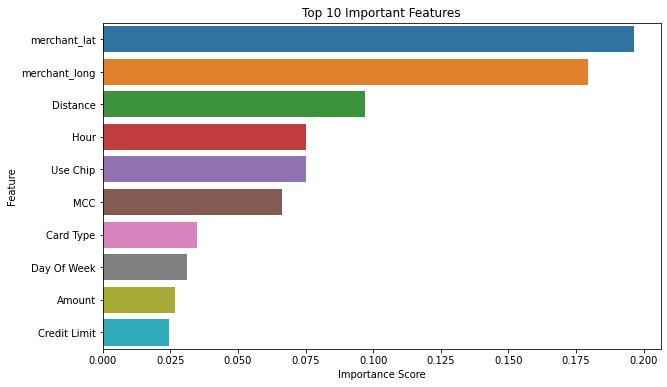

In [91]:
# Feature importance

# Create a list of feature names (assuming you have them in a specific order)
feature_names = ["Amount", "Use Chip", "MCC", "Errors?", "Current Age", "Gender", "State", "Latitude", "Longitude", 
                 "FICO Score", "Num Credit Cards", "Card Brand", "Card Type", "Has Chip", "Cards Issued", "Credit Limit", 
                 "Year PIN last Changed", "Card on Dark Web", "merchant_lat", "merchant_long", "Month", "Day Of Week", "Day", 
                 "Hour", "DaysSinceAcctOpen", "DaysToExpire", "Distance"]  

# Assuming that `best_model` is the trained XGBoost model
feature_importances = best_model.feature_importances_

# Create a DataFrame to store feature names and their importance scores
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the features by importance (descending order)
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Select the top N features (e.g., top 10)
top_n = 10
top_features = feature_importance_df.head(top_n)

# Plot the top N important features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title(f'Top {top_n} Important Features')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()